# How to use TRAP for reducing direct imaging data: a simple example

This notebook shows how to apply the TRAP algorithm (Samland et al. 2020) to data that is shifted and pre-aligned with the center of the images. The data included in this package for testing and demonstration purposes is the same (cropped) VLT/SPHERE-IRDIS 51 Eridani b data in the K1 band that has been used in the paper describing the algorithm. This notebook can be used as reference for your own data and data reduction. Don't be scared by the text, this is mostly to provide additional information to, hopefully, mostly self-explanatory docstring and to describe the workflow and caveats. Running the reduction itself is very straightforward. Before going through this notebook, please make sure you installed the package formally using "pip install ." in the downloaded git folder, or using the "-e" option if you're going to change the code-base itself.

Let us start by importing everything we need from generic packages used for data manipulation / plotting and some useful high-level functionality from TRAP. The "pkg_resource" package is only used for locating the test data included in this package. If you want to run and modify this notebook, please download it and put it somewhere where you keep your science stuff, you don't want to manipulate it in the git folder since that is messy. :)

In [1]:
import os

import numpy as np
from astropy import units as u
from astropy.io import fits

In [2]:
from trap.parameters import Instrument, Reduction_parameters
from trap.plotting_tools import plot_scale
from trap.reduction_wrapper import run_complete_reduction

## Setting up the Instrument and Reduction parameters

We need the pipeline to be aware of some attributes of the instrument we are using, like the pixel scale to translate coordinates and angular sizes, and the telescope diameter which is needed to compute the theoretical size of the point-spread function of the telescope. For this we create an Instrument-class object. Detector properties such as the read-noise and gain can be additionally specified if you want TRAP to take them into account when modeling the systematics. If you provide a variance data cube that already contains all the uncertainties of the input data later in, just leave them on their default value so that you do not take them into account twice. The example given below is for the test data packaged with the pipeline.

In [3]:
used_instrument = Instrument(
    name='IRDIS',
    wavelengths=np.array([2.11]) * u.micron,
    pixel_scale=u.pixel_scale(0.01225 * u.arcsec / u.pixel),
    telescope_diameter=7.99 * u.m,
    detector_gain=1.75,
    readnoise=6)

Next we need to specify the details of the reduction parameters, i.e. what type of TRAP reduction to we want to perform? What separation range do we want to look at? How should the training set (the reference pixels) be selected on which to train the systematics lightcurve model on? Everything related to the reduction in summarized in the "Reduction_parameters"-class. To be honest it is a bit unwieldy with a lot of things that can be tweak and including parameters for functions that are currently still in the testing and developing stage. In general however, the default values should be sensible for most applications and correspond mostly to the settings as shown in the paper. For now we will stick with the default parameters and only explicitly define some parameters that you are likely to play around with or *actually* need to change for your own reduction. We'll dump the results in our home directory for now, but of course you're free to change this!

In [6]:
from pathlib import Path

result_folder = os.path.join(str(Path.home()), 'trap_reduction')

In [22]:
reduction_parameters = Reduction_parameters(
    search_region_inner_bound=31,
    search_region_outer_bound=43,
    data_auto_crop=True,
    data_crop_size=None,
    right_handed=True,
    include_noise=False,
    yx_known_companion_position=[-35.95, -8.43],
    known_companion_contrast=None,
    use_multiprocess=True,
    ncpus=4,
    result_folder=result_folder,
    # Reduction and signal masks
    autosize_masks_in_lambda_over_d=True,
    reduction_mask_size_in_lambda_over_d=1.1,
    signal_mask_size_in_lambda_over_d=2.1,
    reduction_mask_psf_size=19,
    signal_mask_psf_size=19,
    # Regressor stuff
    annulus_width=5,
    add_radial_regressors=True,
    include_opposite_regressors=True,
    # Contrast curve / normalization stuff
    contrast_curve=True,
    contrast_curve_sigma=5.,
    normalization_width=3,
    companion_mask_radius=11)

## To explain the above parameters in a bit more detail than what the docstrings say, they should be mostly self-explanatory, but still!

- The first two "search_region"-parameters define the inner and outer separation for the final detection map that will be created, i.e. this is the separation range (in pixel) in which we will search for companions. As noted in the paper, TRAP can get quite slow if we choose a large outer bound, but in general we don't really care about large separations because TRAP, as a temporal model, is expected to perform better at small separations and loses its edge far out.

- The "right_handed"-parameter gives the rotation direction of the field-of-view... Honestly, if you're working with a new instrument you just have to try it out, best with a data set where you know that there is a companion so you can check. It depends on the definition of parallactic angles used and exactly how the instrument is designed. For data produced by the SPHERE Data Center the parallactic angles work such, that "right_handed" is True, but for most other data I tried TRAP on it was the other way around.

- Since TRAP creates a time-series model for a pixel and is trained by non-local pixels, it is important to excluded known companions from the training data. The "yx_known_companion_position" allows you to specifiy the relative position of a companion to be excluded from the regressor selection (otherwise, just set it to None or ignore it in the init). Usually you don't know beforehand whether there is a signiicant companion in the data, so you just ignore it in the first run and specifiy it in subsequent reductions for the same data based on the location of the companion in the detection map. Luckily, for the test data we know the location of 51 Eri b already. :)

- You can run TRAP on multiple cores, specified by the "use_multiprocessing" and if True "ncpus" for the number of cores to be used. Running TRAP on multiple cores can significantly decrease the processing time. However, given how right now only a simple "multiprocessing.pool" implementation is used, it scales very poorly with memory use (i.e. every core has to have a copy of the whole data). If you run it on a laptop, I'd recommend playing around with small numbers first and monitor your memory usage before going all out. Since the data is cropped automatically to the "search_region_outer_bound" size (plus some extra space for regressor selection and such), memory usage goes down sharply with a smaller outer bound of the search area.

- The "result_folder"-parameter specifies the path to the directory where you want to put the analysis results.

- The next parameters specify the size of the PSF stamp to be used in the reduction. First, "autosize_masks_in_lambda_over_d" specifies whether you want to give the size in $\lambda/D$. In this case the next two parameters count (2.1 corresponds roughly to the size of the PSF including the first Airy-ring). If not, you can give a fixed size in pixel using the next two parameters directly. As you can see there are two masks: the "signal_mask" and the "reduction_mask". The signal mask determines the size of the companion PSF that a companion affects with flux, this is important for removing pixels from the training data that could be contaminated by a planet at the point at which we currently search for a signal. The reduction mask determined the size of the PSF stamp used to determine which pixels to fit with a model given the assumed search position. The signal mask size should always be larger or equal to the reduction mask size. The reduction mask basically corresponds to $\mathcal{P}_{\mathcal{Y}}$ in Samland et al. 2020.

- Next we have the parameters controlling what to include in the regressors: "annulus_width" is the width of the regressor annulus in pixel. If "add_radial_regressors" is True pixels radially inside and outside of reduction area will be added to pool of regressor pixels. "include_opposite_regressors" includes additional regressors corresponding to the reduction area, but mirrored at the origin (host star).

- With the last four parameters above your control contrast curve creation and the empirical calibration of the uncertainties that is used in normalizing the SNR map. Switch on or off the automatic contrast curve creation at the end is mostly for people who work on a remote machine that has troubles plotting. Since making the contrast curve doesn't take any time at all and your computer doesn't have trouble plotting, just keep it on. The "normalization_width" is the width of the annulus used for normalizing the SNR map and "companion_mask_size" gives the radius of the mask (in pixel) used to mask out the companion in the normalization procedure and contrast curve statistics.

If you want to learn more about the available options, although it can be a bit overwhelming, feel free to take a look at the docstrings!

In [30]:
Instrument?

Init signature:
Instrument(
    name,
    pixel_scale,
    telescope_diameter,
    detector_gain=1.0,
    readnoise=0.0,
    instrument_type='photometry',
    wavelengths=None,
    spectral_resolution=None,
    filters=None,
    transmission=None,
)
Docstring:     
Important information on the instrument.

Parameters
----------
name : str
    Name of the instrument used.
pixel_scale : `~astropy.units.Quantity`
    The pixel scale either in units of angle/pixel or pixel/angle.
telescope_diameter : `~astropy.units.Quantity`
    The diameter of the telescopy in units of length.
detector_gain : float
    The detector gain (electrons/ADU).
readnoise : float
    The detector read noise (e rms/pix/readout).
instrument_type : str, optional
    Can take values 'phot', 'ifu' or None. Only used for spectral
    template matching in detection.
    Default is 'photometry'.
wavelengths : `~astropy.units.Quantity`
    The (central) wavelengths of the data as sampled by this instrument.
    Effective 

In [31]:
Reduction_parameters?

Init signature:
Reduction_parameters(
    search_region=None,
    search_region_inner_bound=1,
    search_region_outer_bound=55,
    oversampling=1,
    data_auto_crop=False,
    data_crop_size=None,
    right_handed=True,
    include_noise=False,
    temporal_model=True,
    temporal_plus_spatial_model=False,
    second_stage_trap=False,
    remove_model_from_spatial_training=True,
    remove_bad_residuals_for_spatial_model=True,
    spatial_model=False,
    local_temporal_model=False,
    local_spatial_model=False,
    protection_angle=0.5,
    spatial_components_fraction=0.3,
    spatial_components_fraction_after_trap=0.1,
    highpass_filter=None,
    remove_known_companions=False,
    yx_known_companion_position=None,
    known_companion_contrast=None,
    use_multiprocess=False,
    ncpus=1,
    prefix='',
    result_folder='./',
    inject_fake=False,
    true_position=None,
    true_contrast=None,
    read_injection_files=False,
    injection_sigma=5,
    reduce_single_position

## Reading in the data and some additional information for the reduction

Nooooow, we actually need some data! For this example we will use the SPHERE 51 Eri b data packaged in TRAP. We need:

- The **data cube** containing the main science observation (usually coronagraphic, but of course it also works on non-coronagraphic sequences too). In the case of running the reduction pre-aligned data (such as in this example), the center is assumed to be centered on the pixel with the index (image_size_y // 2, image_size_x // 2), where "//" is the floor-operator in Python.
- An **unsaturated model of the PSF** used as forward model for the companion. It should be scaled to the same exposure time and filter (usually there is an neutral density filter) as the science observation.
- A list containing the **parallactic angles for each frame**
- An astropy quantity array containing the **wavelengths of each channel**.

Optionally:
- A cube of the same dimension as the science data, containing the **inverse variance for each data point**. If you have this information it is recommended to include it in the fit, as it automatically puts less weight on bad data. If "include_noise" is True, the pipeline will first check if a variance cube is provide, otherwise it will assume the data only contains photon noise and the read noise specified in the Instrument-object. This is of course not entirely true if for example your pre-reduction of the data already removed a significant sky background or rescaled the amplitude of the data, so beware of these effects.
- A list containing **indices of bad frames**. TRAP is very robust against anomalous frames compared to traditional spatial models, so unless some data seems completely un-usable I wouldn't recommend removing data aggresively or even at all)
- An array of **companion flux amplitude modulation factors** (centered around 1). The first axis should be wavelength, the second time. You can account for flux variation in the companion model by, for example, taking into account the frame-to-frame change in satellite spot brightness. The companion signal will be multiplied by this factor in the forward model.

If the paths of the demo data is not recognized properly on your installation, you can simply change the folder by hand to the directory of the package (or download it separately somewhere else)

In [23]:
data_full = fits.getdata(
    './test_data/science_cube.fits')[:, ::2]
flux_psf_full = fits.getdata(
    './test_data/psf_model.fits')
pa = fits.getdata(
    './test_data/parallactic_angles.fits')[::2]

inverse_variance_full = None
bad_frames = None
amplitude_modulation_full = None

Noticed that we only use every second frame (in the time axis of the data cube and parallactic angle) here to save some time on the example! In a normal analysis you should use all the data, unless you want to test something.

In [24]:
data_full.shape

(1, 128, 127, 127)

The data includes a wavelength dimension (axis=0), but we included only the K1 wavelength in the test data.
Let's have a quick peak at the first frame of the (only wavelength). The "plot_scale" routine automatically plots the zscale image with colorbar.

<Axes: xlabel='Offset (pixel)', ylabel='Offset (pixel)'>

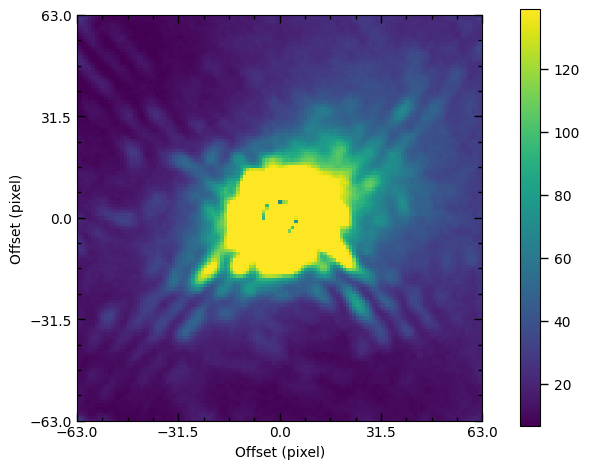

In [25]:
plot_scale(data_full[0, 0], relative_to_center=True, figsize=(6, 6))

And that's it! For a basic reduction with an already pre-aligned/centered cube this is all that is needed.

## Setting up the reduction

The heavy lifting is already done, we now just have two more high-level parameter we can set.

In [26]:
wavelength_indices = [0, 1] # or None to reduce all wavelength channels
temporal_components_fraction = [0.2]

If you provided a cube with the first axis being wavelength (for example when using an IFS or dual-band imager), you can explicitly specify which wavelength indices you want to reduce. Chosing None or not setting it explicitly a reduction of all wavelengths will be performed.

The "temporal_components_fraction"-parameter described how many principal components (compared to be maximum available number, i.e. the number of frames in the sequences) you want to use. If more than one entry is provided in the list it will loop over the different options and provide output for all of them.

## Starting the reduction

Running the reduction on one core in the 1 - 45 pixel separation range can take about an hour (with the above parameters). Best time to make coffee or go for a long walk! Or run it one a bigger machine. ;)

If you don't want to wait for an hour you can skip further down this notebook, where I show a small targeted reduction that may still be useful in some cases.

In [27]:
run_reduction = True

In [28]:
if run_reduction:
    all_results = run_complete_reduction(
        data_full=data_full,
        flux_psf_full=flux_psf_full,
        pa=pa,
        instrument=used_instrument,
        reduction_parameters=reduction_parameters,
        temporal_components_fraction=temporal_components_fraction,
        wavelength_indices=wavelength_indices,
        inverse_variance_full=inverse_variance_full,
        bad_frames=bad_frames,
        amplitude_modulation_full=amplitude_modulation_full)

[2024-04-02 16:18:24,580 I 26150 26150] (gcs_server) io_service_pool.cc:35: IOServicePool is running with 1 io_service.
[2024-04-02 16:18:24,582 I 26150 26150] (gcs_server) event.cc:234: Set ray event level to warning
[2024-04-02 16:18:24,582 I 26150 26150] (gcs_server) event.cc:342: Ray Event initialized for GCS
[2024-04-02 16:18:24,582 I 26150 26150] (gcs_server) gcs_server.cc:74: GCS storage type is StorageType::IN_MEMORY
[2024-04-02 16:18:24,583 I 26150 26150] (gcs_server) gcs_init_data.cc:42: Loading job table data.
[2024-04-02 16:18:24,583 I 26150 26150] (gcs_server) gcs_init_data.cc:54: Loading node table data.
[2024-04-02 16:18:24,583 I 26150 26150] (gcs_server) gcs_init_data.cc:80: Loading actor table data.
[2024-04-02 16:18:24,583 I 26150 26150] (gcs_server) gcs_init_data.cc:93: Loading actor task spec table data.
[2024-04-02 16:18:24,583 I 26150 26150] (gcs_server) gcs_init_data.cc:66: Loading placement group table data.
[2024-04-02 16:18:24,583 I 26150 26150] (gcs_server) g

2024-04-02 16:18:26,127	INFO (dashboard) head.py:150 -- Dashboard head grpc address: 0.0.0.0:33951
2024-04-02 16:18:26,134	INFO (dashboard) head.py:254 -- Starting dashboard metrics server on port 44227
2024-04-02 16:18:26,137	INFO (dashboard) utils.py:112 -- Get all modules by type: DashboardHeadModule
2024-04-02 16:18:26,141	INFO (monitor) monitor.py:688 -- Starting monitor using ray installation: /home/samland/miniconda3/envs/trap_test/lib/python3.11/site-packages/ray/__init__.py
2024-04-02 16:18:26,141	INFO (monitor) monitor.py:689 -- Ray version: 2.10.0
2024-04-02 16:18:26,141	INFO (monitor) monitor.py:690 -- Ray commit: 09abba26b5bf2707639bb637c208d062a47b46f6
2024-04-02 16:18:26,141	INFO (monitor) monitor.py:691 -- Monitor started with command: ['/home/samland/miniconda3/envs/trap_test/lib/python3.11/site-packages/ray/autoscaler/_private/monitor.py', '--logs-dir=/tmp/ray/session_2024-04-02_16-18-24_544570_24819/logs', '--logging-rotate-bytes=536870912', '--logging-rotate-backup-

[2024-04-02 16:18:26,581 I 26230 26230] (raylet) main.cc:176: Setting cluster ID to: 672b3416921931128f657e05db39115b94f903ddca9745d5a9e06907
[2024-04-02 16:18:26,584 I 26230 26230] (raylet) main.cc:239: Raylet is not set to kill unknown children.
[2024-04-02 16:18:26,584 I 26230 26230] (raylet) io_service_pool.cc:35: IOServicePool is running with 1 io_service.
[2024-04-02 16:18:26,585 I 26230 26230] (raylet) store_runner.cc:32: Allowing the Plasma store to use up to 1.94491GB of memory.
[2024-04-02 16:18:26,585 I 26230 26230] (raylet) store_runner.cc:48: Starting object store with directory /dev/shm, fallback /tmp/ray, and huge page support disabled
[2024-04-02 16:18:26,585 I 26230 26256] (raylet) dlmalloc.cc:154: create_and_mmap_buffer(1944977416, /dev/shm/plasmaXXXXXX)
[2024-04-02 16:18:26,586 I 26230 26256] (raylet) store.cc:564: ========== Plasma store: =================
Current usage: 0 / 1.94491 GB
- num bytes created total: 0
0 pending objects of total size 0MB
- objects spilla

:job_id:01000000
:job_id:01000000
:job_id:01000000
:job_id:01000000


cc:35: IOServicePool is running with 1 io_service.
[2024-04-02 16:18:27,270 I 26293 26293] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) grpc_server.cc:129: worker server started, listening on port 44537.
[2024-04-02 16:18:27,275 I 26293 26293] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) core_worker.cc:252: Initializing worker at address: 192.168.194.218:44537, worker ID 69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5, raylet 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867
[2024-04-02 16:18:27,276 I 26293 26293] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) task_event_buffer.cc:177: Reporting task events to GCS every 1000ms.
[2024-04-02 16:18:27,277 I 26230 26256] (raylet) object_store.cc:35: Object store current usage 8e-09 / 1.94491 GB.
[2024-04-02 16:18:27,277 I 26293 26293] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) core_worker.cc:67

  0%|          | 0/2584 [00:00<?, ?it/s]

[2024-04-02 16:18:27,440 I 24819 26289] (python-core-driver-01000000ffffffffffffffffffffffffffffffffffffffffffffffff) actor_manager.cc:214: received notification on actor, state: PENDING_CREATION, actor_id: b65ee3cb22e08bc49027572f01000000, ip address: , port: 0, worker_id: NIL_ID, raylet_id: 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867, num_restarts: 0, death context type=CONTEXT_NOT_SET
[2024-04-02 16:18:27,505 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.
[2024-04-02 16:18:27,933 I 26479 26479] (python-core-worker-8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa) core_worker_process.cc:107: Constructing CoreWorkerProcess. pid: 26479
[2024-04-02 16:18:27,936 I 26479 26479] (python-core-worker-8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa) io_service_pool.cc:35: IOServicePool is running with 1 io_service.
[2024-04-02 16:18:27,938 I 26479 26479] (python-core-worker-8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947

:job_id:01000000
:actor_name:ProgressBarActor


:task_name:trap_search_region
:task_name:trap_search_region
[2024-04-02 16:18:30,206 I 26293 26293] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) direct_actor_task_submitter.cc:36: Set max pending calls to -1 for actor b65ee3cb22e08bc49027572f01000000
[2024-04-02 16:18:30,212 I 26290 26290] (python-core-worker-f455b70d65dcf6d5da487942b3a972c2f0f7cafbe70f1232a4d822d1) direct_actor_task_submitter.cc:36: Set max pending calls to -1 for actor b65ee3cb22e08bc49027572f01000000


:task_name:trap_search_region
:task_name:trap_search_region
  0%|          | 1/2584 [00:03<2:11:41,  3.06s/it]:task_name:trap_search_region
:task_name:trap_search_region
  0%|          | 3/2584 [00:03<35:52,  1.20it/s]  

[2024-04-02 16:18:30,411 I 26293 26369] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) actor_manager.cc:214: received notification on actor, state: ALIVE, actor_id: b65ee3cb22e08bc49027572f01000000, ip address: 192.168.194.218, port: 33133, worker_id: 8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa, raylet_id: 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867, num_restarts: 0, death context type=CONTEXT_NOT_SET
[2024-04-02 16:18:30,411 I 26293 26369] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) direct_actor_task_submitter.cc:237: Connecting to actor b65ee3cb22e08bc49027572f01000000 at worker 8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa
[2024-04-02 16:18:30,412 I 26479 26479] (python-core-worker-8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa) out_of_order_actor_scheduling_queue.cc:40: Setting actor as asyncio with max_concurrency=1000, and defined concurrency groups are:

[2024-04-02 16

  0%|          | 7/2584 [00:03<11:36,  3.70it/s]

[2024-04-02 16:18:30,642 I 26291 26291] (python-core-worker-81010d8036a9120e397a505ba7f125820c9cb52b6f18851e2fd0f87a) direct_actor_task_submitter.cc:36: Set max pending calls to -1 for actor b65ee3cb22e08bc49027572f01000000
[2024-04-02 16:18:30,808 I 26292 26399] (python-core-worker-3ad8ab9848f0600c100054a7ae4a55a37bad6b27fa32420297c40be2) actor_manager.cc:214: received notification on actor, state: ALIVE, actor_id: b65ee3cb22e08bc49027572f01000000, ip address: 192.168.194.218, port: 33133, worker_id: 8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa, raylet_id: 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867, num_restarts: 0, death context type=CONTEXT_NOT_SET
[2024-04-02 16:18:30,808 I 26292 26399] (python-core-worker-3ad8ab9848f0600c100054a7ae4a55a37bad6b27fa32420297c40be2) direct_actor_task_submitter.cc:237: Connecting to actor b65ee3cb22e08bc49027572f01000000 at worker 8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa
[2024-04-02 16:18:30,810 I 26479 26479] 

  0%|          | 9/2584 [00:03<08:12,  5.23it/s]

[2024-04-02 16:18:30,872 I 26291 26457] (python-core-worker-81010d8036a9120e397a505ba7f125820c9cb52b6f18851e2fd0f87a) actor_manager.cc:214: received notification on actor, state: ALIVE, actor_id: b65ee3cb22e08bc49027572f01000000, ip address: 192.168.194.218, port: 33133, worker_id: 8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa, raylet_id: 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867, num_restarts: 0, death context type=CONTEXT_NOT_SET
[2024-04-02 16:18:30,872 I 26291 26457] (python-core-worker-81010d8036a9120e397a505ba7f125820c9cb52b6f18851e2fd0f87a) direct_actor_task_submitter.cc:237: Connecting to actor b65ee3cb22e08bc49027572f01000000 at worker 8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa
[2024-04-02 16:18:30,880 I 26479 26479] (python-core-worker-8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa) out_of_order_actor_scheduling_queue.cc:40: Setting actor as asyncio with max_concurrency=1000, and defined concurrency groups are:



  0%|          | 12/2584 [00:03<05:59,  7.16it/s]2024-04-02 16:18:31,166	INFO (monitor) autoscaler.py:147 -- The autoscaler took 0.0 seconds to fetch the list of non-terminated nodes.
2024-04-02 16:18:31,167	INFO (monitor) autoscaler.py:427 -- 
======== Autoscaler status: 2024-04-02 16:18:31.167307 ========
Node status
---------------------------------------------------------------
Active:
 1 node_67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 4.0/4.0 CPU
 0B/3.62GiB memory
 15.76MiB/1.81GiB object_store_memory

Demands:
 {'CPU': 1.0}: 4+ pending tasks/actors
2024-04-02 16:18:31,169	INFO (monitor) autoscaler.py:470 -- The autoscaler took 0.002 seconds to complete the update iteration.
  4%|▍         | 113/2584 [00:08<01:34, 26.01it/s]2024-04-02 16:18:36,177	INFO (monitor) autoscaler.py:147 -- The autoscaler took 0.0 seconds to fetch t

:task_name:trap_search_region
[2024-04-02 16:19:19,888 I 26293 26293] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) direct_actor_task_submitter.cc:36: Set max pending calls to -1 for actor b65ee3cb22e08bc49027572f01000000
[2024-04-02 16:19:19,961 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.


 49%|████▉     | 1278/2584 [00:52<00:49, 26.32it/s]

:task_name:trap_search_region
[2024-04-02 16:19:20,218 I 26291 26291] (python-core-worker-81010d8036a9120e397a505ba7f125820c9cb52b6f18851e2fd0f87a) direct_actor_task_submitter.cc:36: Set max pending calls to -1 for actor b65ee3cb22e08bc49027572f01000000
[2024-04-02 16:19:20,261 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.


 50%|█████     | 1302/2584 [00:53<00:46, 27.61it/s]:task_name:trap_search_region
2024-04-02 16:19:21,243	INFO (monitor) autoscaler.py:147 -- The autoscaler took 0.0 seconds to fetch the list of non-terminated nodes.
2024-04-02 16:19:21,243	INFO (monitor) autoscaler.py:427 -- 
======== Autoscaler status: 2024-04-02 16:19:21.243462 ========
Node status
---------------------------------------------------------------
Active:
 1 node_67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 4.0/4.0 CPU
 0B/3.62GiB memory
 16.12MiB/1.81GiB object_store_memory

Demands:
 {'CPU': 1.0}: 2+ pending tasks/actors
2024-04-02 16:19:21,244	INFO (monitor) autoscaler.py:470 -- The autoscaler took 0.001 seconds to complete the update iteration.
 51%|█████     | 1305/2584 [00:53<00:46, 27.49it/s]

:task_name:trap_search_region
[2024-04-02 16:19:21,177 I 26292 26292] (python-core-worker-3ad8ab9848f0600c100054a7ae4a55a37bad6b27fa32420297c40be2) direct_actor_task_submitter.cc:36: Set max pending calls to -1 for actor b65ee3cb22e08bc49027572f01000000
[2024-04-02 16:19:21,263 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.


 51%|█████     | 1323/2584 [00:54<00:45, 27.70it/s]

:task_name:trap_search_region
[2024-04-02 16:19:21,792 I 26290 26290] (python-core-worker-f455b70d65dcf6d5da487942b3a972c2f0f7cafbe70f1232a4d822d1) direct_actor_task_submitter.cc:36: Set max pending calls to -1 for actor b65ee3cb22e08bc49027572f01000000
[2024-04-02 16:19:21,863 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.


 54%|█████▍    | 1398/2584 [00:57<00:40, 29.23it/s]

[2024-04-02 16:19:24,618 I 26150 26150] (gcs_server) gcs_server.cc:250: GcsNodeManager: 
- RegisterNode request count: 1
- DrainNode request count: 0
- GetAllNodeInfo request count: 35
- GetInternalConfig request count: 1

GcsActorManager: 
- RegisterActor request count: 1
- CreateActor request count: 1
- GetActorInfo request count: 5
- GetNamedActorInfo request count: 0
- GetAllActorInfo request count: 1
- KillActor request count: 0
- ListNamedActors request count: 0
- Registered actors count: 1
- Destroyed actors count: 0
- Named actors count: 0
- Unresolved actors count: 0
- Pending actors count: 0
- Created actors count: 1
- owners_: 1
- actor_to_register_callbacks_: 0
- actor_to_create_callbacks_: 0
- sorted_destroyed_actor_list_: 0

GcsResourceManager: 
- GetAllAvailableResources request count0
- GetAllResourceUsage request count: 12

GcsPlacementGroupManager: 
- CreatePlacementGroup request count: 0
- RemovePlacementGroup request count: 0
- GetPlacementGroup request count: 0
- G

 56%|█████▌    | 1445/2584 [00:58<00:36, 31.31it/s]2024-04-02 16:19:26,247	INFO (monitor) autoscaler.py:147 -- The autoscaler took 0.0 seconds to fetch the list of non-terminated nodes.
2024-04-02 16:19:26,247	INFO (monitor) autoscaler.py:427 -- 
======== Autoscaler status: 2024-04-02 16:19:26.247775 ========
Node status
---------------------------------------------------------------
Active:
 1 node_67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 4.0/4.0 CPU
 0B/3.62GiB memory
 16.49MiB/1.81GiB object_store_memory

Demands:
 (no resource demands)
2024-04-02 16:19:26,249	INFO (monitor) autoscaler.py:470 -- The autoscaler took 0.002 seconds to complete the update iteration.
 57%|█████▋    | 1461/2584 [00:59<00:37, 30.12it/s]

[2024-04-02 16:19:26,586 I 26230 26256] (raylet) store.cc:564: ========== Plasma store: =================
Current usage: 0.0172865 / 1.94491 GB
- num bytes created total: 17286558
0 pending objects of total size 0MB
- objects spillable: 4
- bytes spillable: 763783
- objects unsealed: 0
- bytes unsealed: 0
- objects in use: 12
- bytes in use: 17286510
- objects evictable: 0
- bytes evictable: 0

- objects created by worker: 12
- bytes created by worker: 17286510
- objects restored: 0
- bytes restored: 0
- objects received: 0
- bytes received: 0
- objects errored: 0
- bytes errored: 0

[2024-04-02 16:19:26,605 I 26230 26230] (raylet) node_manager.cc:502: [state-dump] NodeManager:
[state-dump] Node ID: 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867
[state-dump] Node name: 192.168.194.218
[state-dump] InitialConfigResources: {memory: 38898130950000, CPU: 40000, node:__internal_head__: 10000, node:192.168.194.218: 10000, object_store_memory: 19449065470000}
[state-dump] ClusterTas

 57%|█████▋    | 1481/2584 [00:59<00:37, 29.43it/s]

[2024-04-02 16:19:27,278 I 26293 26369] (python-core-worker-69c6c1dc4616d397073bbb3013e5e16df61e597ef24605aedf5f5bc5) core_worker.cc:614: Event stats:


Global stats: 2033 total (9 active)
Queueing time: mean = 52.885 us, max = 7.320 ms, min = 7.296 us, total = 107.514 ms
Execution time:  mean = 26.626 ms, total = 54.130 s
Event stats:
	CoreWorker.RecoverObjects - 600 total (1 active), Execution time: mean = 11.738 us, total = 7.043 ms, Queueing time: mean = 75.031 us, max = 4.905 ms, min = 14.133 us, total = 45.019 ms
	CoreWorkerService.grpc_client.PushTask - 375 total (0 active), Execution time: mean = 3.818 ms, total = 1.432 s, Queueing time: mean = 0.000 s, max = -0.000 s, min = 9223372036.855 s, total = 0.000 s
	CoreWorkerDirectActorTaskSubmitter::SubmitTask - 375 total (0 active), Execution time: mean = 305.915 us, total = 114.718 ms, Queueing time: mean = 26.751 us, max = 79.696 us, min = 12.862 us, total = 10.032 ms
	CoreWorkerService.grpc_client.PushTask.OnReplyReceived - 375 

 58%|█████▊    | 1501/2584 [01:00<00:35, 30.42it/s]

[2024-04-02 16:19:27,946 I 26479 26511] (python-core-worker-8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa) core_worker.cc:614: Event stats:


Global stats: 6867 total (9 active)
Queueing time: mean = 23.223 us, max = 5.924 ms, min = -0.000 s, total = 159.472 ms
Execution time:  mean = 9.194 ms, total = 63.136 s
Event stats:
	CoreWorkerService.grpc_server.PushTask - 2984 total (1 active), Execution time: mean = 21.074 ms, total = 62.884 s, Queueing time: mean = 0.000 s, max = -0.000 s, min = 9223372036.855 s, total = 0.000 s
	CoreWorkerService.grpc_server.PushTask.HandleRequestImpl - 2984 total (0 active), Execution time: mean = 59.612 us, total = 177.882 ms, Queueing time: mean = 33.732 us, max = 4.801 ms, min = 2.556 us, total = 100.657 ms
	CoreWorker.RecoverObjects - 600 total (1 active), Execution time: mean = 10.730 us, total = 6.438 ms, Queueing time: mean = 68.513 us, max = 5.447 ms, min = -0.000 s, total = 41.108 ms
	CoreWorker.ExitIfParentRayletDies - 61 total (1 act

 62%|██████▏   | 1590/2584 [01:03<00:33, 29.84it/s]2024-04-02 16:19:31,253	INFO (monitor) autoscaler.py:147 -- The autoscaler took 0.0 seconds to fetch the list of non-terminated nodes.
2024-04-02 16:19:31,253	INFO (monitor) autoscaler.py:427 -- 
======== Autoscaler status: 2024-04-02 16:19:31.253239 ========
Node status
---------------------------------------------------------------
Active:
 1 node_67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 4.0/4.0 CPU
 0B/3.62GiB memory
 16.49MiB/1.81GiB object_store_memory

Demands:
 (no resource demands)
2024-04-02 16:19:31,254	INFO (monitor) autoscaler.py:470 -- The autoscaler took 0.001 seconds to complete the update iteration.
 67%|██████▋   | 1740/2584 [01:08<00:28, 29.13it/s]2024-04-02 16:19:36,257	INFO (monitor) autoscaler.py:147 -- The autoscaler took 0.0 seconds to fetch the list of no

[2024-04-02 16:20:09,712 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.
[2024-04-02 16:20:09,912 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.


100%|█████████▉| 2580/2584 [01:43<00:00, 17.19it/s]

[2024-04-02 16:20:10,713 I 26230 26230] (raylet) local_resource_manager.cc:287: Object store memory is not idle.


100%|██████████| 2584/2584 [01:43<00:00, 24.90it/s]
2024-04-02 16:20:11,299	INFO (monitor) autoscaler.py:147 -- The autoscaler took 0.0 seconds to fetch the list of non-terminated nodes.
2024-04-02 16:20:11,299	INFO (monitor) autoscaler.py:427 -- 
======== Autoscaler status: 2024-04-02 16:20:11.299693 ========
Node status
---------------------------------------------------------------
Active:
 1 node_67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 1.0/4.0 CPU
 0B/3.62GiB memory
 17.03MiB/1.81GiB object_store_memory

Demands:
 (no resource demands)
2024-04-02 16:20:11,300	INFO (monitor) autoscaler.py:470 -- The autoscaler took 0.001 seconds to complete the update iteration.


Main reduction computation time:
0:01:43.873539
[2024-04-02 16:20:11,275 I 26150 26150] (gcs_server) gcs_actor_manager.cc:798: Actor b65ee3cb22e08bc49027572f01000000 is out of scope, destroying actor, job id = 01000000
[2024-04-02 16:20:11,276 I 26150 26150] (gcs_server) gcs_actor_manager.cc:816: Destroying actor, actor id = b65ee3cb22e08bc49027572f01000000, job id = 01000000
[2024-04-02 16:20:11,277 I 24819 26289] (python-core-driver-01000000ffffffffffffffffffffffffffffffffffffffffffffffff) actor_manager.cc:214: received notification on actor, state: DEAD, actor_id: b65ee3cb22e08bc49027572f01000000, ip address: 192.168.194.218, port: 33133, worker_id: 8fe5a297e8e08a38dc9a446e599a1b55a4204a6fb7dd0b947348f7fa, raylet_id: 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867, num_restarts: 0, death context type=ActorDiedErrorContext
[2024-04-02 16:20:11,277 I 26290 26442] (python-core-worker-f455b70d65dcf6d5da487942b3a972c2f0f7cafbe70f1232a4d822d1) actor_manager.cc:214: received notif

Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 3270, in ray._raylet.check_health
  File "python/ray/_raylet.pyx", line 580, in ray._raylet.check_status
ray.exceptions.RpcError: failed to connect to all addresses; last error: UNKNOWN: ipv4:192.168.194.218:49127: Failed to connect to remote host: Connection refused
2024-04-02 16:20:11,714	ERROR (dashboard) node_head.py:382 -- Cannot reach the node, 67dd93fa28402d6622d8c1c4eb998731349814f8d2d26def49531867. The node may have been terminated.
NoneType: None
2024-04-02 16:20:11,739	ERROR (dashboard) node_head.py:216 -- Error updating nodes.
Traceback (most recent call last):
  File "/home/samland/miniconda3/envs/trap_test/lib/python3.11/site-packages/ray/dashboard/modules/node/node_head.py", line 160, in _update_nodes
    nodes = await self._get_nodes()
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samland/miniconda3/envs/trap_test/lib/python3.11/site-packages/ray/dashboard/modules/node/node_head.py", line 145, 

The (non-normalized) contrast images, as well as the instrument and reduction parameters will be saved in the "result_folder", and are ready to be read into the detection and analysis module.

# Normalization, contrast curves, and detection maps

The detection module takes care of everything else that acts on the basic output of TRAP, such as normalizing the detection map and contrast curves, extracting signals and perform spectral template matching on multi-wavelength data (work in progress). Let us first create the object that will encapsulate the analysis for us (for one specific number of principle components used).

In [29]:
from trap.detection import DetectionAnalysis

component_fraction = temporal_components_fraction[0]
analysis = DetectionAnalysis()
analysis.read_output(
    component_fraction,
    result_folder=reduction_parameters.result_folder,
    reduction_type='temporal',
    read_parameters=True)

For now let us perform a normalization of the SNR map (as described in Samland et al. 2021). Masking all pixels above 5-sigma to avoid contamination by very bright sources. This routine will also compute the contrast curves for us. Unless `inplace` is set to False, the output will be put directly into the analysis object as a directionary called `detection_products`.

In [30]:
detection_threshold = 5.
analysis.contrast_table_and_normalization(
    save=False,
    mask_above_sigma=detection_threshold)

In [31]:
analysis.detection_products.keys()

dict_keys(['normalized_detection_cube', 'uncertainty_cube', 'median_uncertainty_cube', 'contrast_tables', 'contrast_table'])

The `detection_products` contains the `normalized_detection_cube`, which contains the normalized detection map for each wavelength reduced (in this case the length is 1).

<Axes: xlabel='Offset (pixel)', ylabel='Offset (pixel)'>

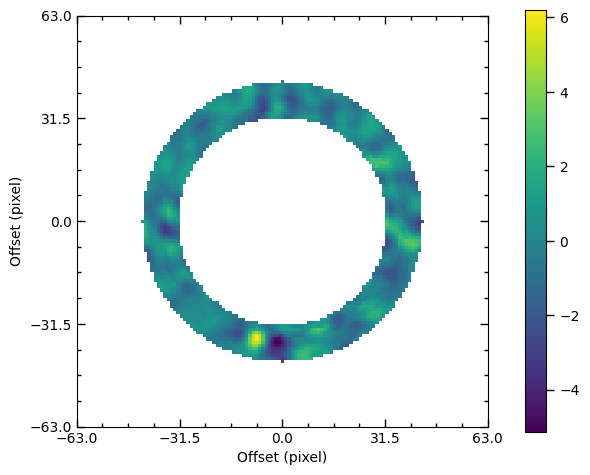

In [32]:
plot_scale(analysis.detection_products['normalized_detection_cube'][0], relative_to_center=True, figsize=(6, 6))

As you can see the 51 Eri b signal is clearly detected as the only significant signal. :)

If you want to know the contrast of the signal you can just go to the contrast map and read off the rough value from at the position of the planet to get a feeling for the results. The contrast map is the first entry of the "detection" output file, the second corresponding to the uncertainties. However, since they are not normalized, it's better to reconstruct the uncertainties from the contrast and normalized SNR map.

In [43]:
contrast = analysis.detection_cube[0, 0]
contrast[contrast == 0.] = np.nan

<Axes: xlabel='Offset (pixel)', ylabel='Offset (pixel)'>

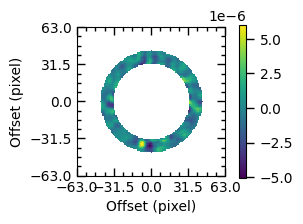

In [44]:
plot_scale(analysis.detection_cube[0, 0], relative_to_center=True)

Identifying and fitting potential candidates.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Extracting candidate spectra.


0it [00:00, ?it/s]

Adjusting outer bound to fit guess position
Auto crop size cropped data to: 127
Number of principal comp. used: 26 of 128
Lambda index: 0 Wavelength: 2.110 micron
lam00_ncomp026_frac0.20
PSF Size: 11


1it [00:00,  3.10it/s]
/home/samland/miniconda3/envs/trap_test/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


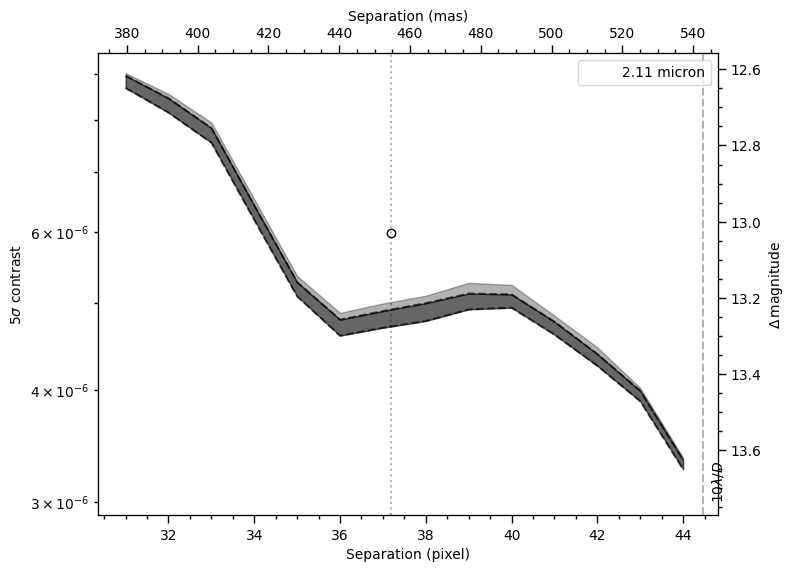

In [45]:
wavelengths = analysis.instrument.wavelengths[analysis.wavelength_indices]
candidate_threshold = 4.5

analysis.detection_and_characterization(
    data_full=data_full,
    flux_psf_full=flux_psf_full,
    pa=pa,
    temporal_components_fraction=temporal_components_fraction,
    inverse_variance_full=inverse_variance_full,
    bad_frames=bad_frames,
    amplitude_modulation_full=amplitude_modulation_full,
    candidate_threshold=candidate_threshold,
    detection_threshold=detection_threshold
)

In [46]:
analysis.validated_companion_table_short

,candidate_id,x,y,x_relative,y_relative,separation,separation_sigma,position_angle,position_angle_sigma,norm_snr_fit_free,peak_pixel_snr,wavelength_index,wavelength,contrast,uncertainty
0,0,54.712305,26.747284,-8.287695,-36.252716,37.187973,NaN,167.122956,NaN,6.901159,6.25344,0,2.11,0.000006,5.476524e-07


Further documentation on the usage of the `DetectionAnalysis`-class will be added soon.